## Club Mahindra DataOlympics

### Loading Packages

In [1]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date
from IPython.display import display
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
from datetime import datetime

In [2]:
import xgboost as xgb
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
from sklearn.model_selection import KFold
from sklearn import metrics

### Custom Functions

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def get_stats(df,columns):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column])
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])
        
def rmse(predictions, actuals): return 100*math.sqrt(((predictions-actuals)**2).mean())

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')

def generate_date_features(df, fldname, drop=True):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"_isweekend"]=df[targ_pre+"Dayofweek"].apply(lambda x:1 if x==5 or x==6 else 0)
    if drop: df.drop(fldname, axis=1, inplace=True)
        

def fix_season_code(df, resort_id, date):
    subset = df.loc[(df['checkin_date']==date) & (df['resort_id']==resort_id)]
    rows = subset.shape[0]
    if rows > 1:
        max_reservations = np.max(subset['reservations'])
        subset=subset[subset['reservations']==max_reservations]
        return subset['season_holidayed_code'].tolist()[0]
    if rows == 1:
        return subset['season_holidayed_code'].tolist()[0]
    else:
        return 1
    
def count_encode(train, test, by_cols, on_col, name, use_test=False):
    temp=train.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    if use_test:
        temp=test.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

### Loading Train and Test datasets

In [5]:
Path = './data/club_mahindra/'

In [6]:
date_columns = ['booking_date', 'checkin_date', 'checkout_date']

In [7]:
%%time
train = pd.read_csv(f'{Path}train.csv'
                         , parse_dates=date_columns
                         , date_parser=dateparse
                        )

CPU times: user 11.3 s, sys: 231 ms, total: 11.6 s
Wall time: 11.6 s


In [8]:
%%time
test = pd.read_csv(f'{Path}test.csv'
                        , parse_dates=date_columns
                        , date_parser=dateparse
                       )

CPU times: user 4.78 s, sys: 90.7 ms, total: 4.87 s
Wall time: 4.87 s


In [9]:
%%time
submission = pd.read_csv(f'{Path}sample_submission.csv')

CPU times: user 129 ms, sys: 22.1 ms, total: 151 ms
Wall time: 149 ms


In [10]:
test['amount_spent_per_room_night_scaled'] = 0

In [11]:
train.shape, test.shape, submission.shape

((341424, 24), (146765, 24), (146765, 2))

In [12]:
display_all(train.head())

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


### Generating features from date columns

In [13]:
for col in date_columns:
    generate_date_features(train, col, drop=False)
    generate_date_features(test, col, drop=False)

### Check for missing values

In [14]:
for df in (train, test):
    missing_stats = df.isnull().sum(axis=0)
    print(missing_stats[missing_stats != 0], '\n')

season_holidayed_code     114
state_code_residence     4764
dtype: int64 

season_holidayed_code      35
state_code_residence     2260
dtype: int64 



### Fix missing values

In [15]:
for df in (train, test):
    print(df.loc[df['season_holidayed_code'].isnull(),'resort_id'].unique(), '\n')

['49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8'
 '9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767'
 '4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a'] 

['49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8'
 '4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a'] 



- Same resorts have season_holidayed_code missing in both train and test data sets

In [16]:
missing_resorts = train.loc[train['season_holidayed_code'].isnull(),'resort_id'].unique().tolist()

In [17]:
missing_resorts_data = train[(train['resort_id'].isin(missing_resorts))
                            & (train['season_holidayed_code'].notnull())]
missing_resorts_data.shape

(45656, 63)

In [18]:
resort_season=missing_resorts_data.groupby(['resort_id'
                                           ,'checkin_date'
                                           ,'season_holidayed_code']
                                         )['reservation_id'].count().reset_index().rename(columns={'reservation_id'
                                                                                                   :'reservations'})

In [19]:
resort_season.head()

,resort_id,checkin_date,season_holidayed_code,reservations
0,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2012-03-08,3.0,1
1,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-01,1.0,10
2,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-02,1.0,13
3,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-03,1.0,6
4,49d180ecf56132819571bf39d9b7b342522a2ac6d23c14...,2015-01-04,1.0,2


In [20]:
for df in (train, test):
    df['season_holidayed_code_new'] = df.apply(lambda x: fix_season_code(resort_season
                                                                          ,x['resort_id']
                                                                          ,x['checkin_date']
                                                                          )
                                                if pd.isnull(x['season_holidayed_code']) else x['season_holidayed_code']
                                              ,axis=1)

In [21]:
sorted(train['state_code_residence'].unique().tolist())

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 13.0,
 14.0,
 nan,
 11.0,
 12.0,
 15.0,
 16.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0]

- state_code_residence 17 is missing in the data and we will impute this in the missing value

In [22]:
for df in (train, test):
    df['state_code_residence'] = df['state_code_residence'].apply(lambda x: 17 if pd.isnull(x) else x)

### Feature Engineering

In [23]:
for df in (train, test):
    df['days_advance_booking'] = (df['checkin_date'] - df['booking_date']).dt.days
    df['advance_booking_anomaly'] = df['days_advance_booking'] < 0
    df['days_stayed'] = (df['checkout_date'] - df['checkin_date']).dt.days
    df['total_guests'] = (df['numberofadults'] + df['numberofchildren'])
    df['guests_pax_ratio'] = df['total_guests']/df['total_pax']
    df['same_state_resort']= np.where(df['state_code_resort'] == df['state_code_residence'], 1, 0)
    df['roomnights'] = np.where(df['roomnights'] < 0, 1, df['roomnights'])
    df['roomsbooked'] = round(df['roomnights']/df['days_stayed'])
    df['guests_per_room'] = df['total_guests']/df['roomsbooked']
    df['peak_month'] = np.where(df['checkin_Month'].isin([4,5,12]), 1, 0)

In [24]:
full_data = train.append(test)

- Finding first booking date for each member

In [25]:
member_first_booking = full_data.groupby(['memberid'
                                  ])['booking_date'
                                  ].min().reset_index().rename(columns={'booking_date':'first_booking_date'})

In [26]:
train = pd.merge(train, member_first_booking, on='memberid', how='left')
test = pd.merge(test, member_first_booking, on='memberid', how='left')

- Feature column to know if this is the first booking of the member

In [27]:
for df in (train, test):
    df['is_first_booking'] = np.where(df['booking_date'] == df['first_booking_date'], 1, 0)

- Feature column for members doing multiple reservations on the same checkin date

In [28]:
train, test = count_encode(train
                           ,test
                           ,['memberid','checkin_date']
                           ,'reservation_id'
                           ,'same_day_reservations'
                           ,True
                          )

- Feature column for counting resort reservations on each checkin date

In [29]:
train, test = count_encode(train
                           ,test
                           ,['resort_id','checkin_date']
                           ,'reservation_id'
                           ,'resort_reservations'
                           ,True
                          )

In [30]:
train.shape, test.shape

((341424, 77), (146765, 77))

- Feature columns to get minimum, maxiumum, mean & median number of guests travelling with a memberid

In [31]:
member_guests_size = train.groupby(['memberid'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

member_guests_size = member_guests_size.rename(columns={'min':'min_total_guests'
                                                          ,'max':'max_total_guests'
                                                          ,'median':'median_total_guests'                                         
                                                          ,'mean':'mean_total_guests'
                                                         }
                                                )

In [32]:
train = pd.merge(train, member_guests_size, on='memberid', how='left')

In [33]:
member_guests_size = test.groupby(['memberid'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

member_guests_size = member_guests_size.rename(columns={'min':'min_total_guests'
                                                          ,'max':'max_total_guests'
                                                          ,'median':'median_total_guests'                                         
                                                          ,'mean':'mean_total_guests'
                                                         }
                                                )

In [34]:
test = pd.merge(test, member_guests_size, on='memberid', how='left')

- Feature columns to get minimum, maxiumum, mean & median number of guests coming to a resort

In [35]:
resort_guests_size = train.groupby(['resort_id'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

resort_guests_size = resort_guests_size.rename(columns={'min':'min_resort_guests'
                                                          ,'max':'max_resort_guests'
                                                          ,'median':'median_resort_guests'                                         
                                                          ,'mean':'mean_resort_guests'
                                                        }
                                                )

In [36]:
train = pd.merge(train, resort_guests_size, on='resort_id', how='left')

In [37]:
resort_guests_size = test.groupby(['resort_id'])['total_guests'].agg(['min'
                                                                      ,'max'
                                                                      ,'mean'
                                                                      ,'median'
                                                                     ]).reset_index()

resort_guests_size = resort_guests_size.rename(columns={'min':'min_resort_guests'
                                                          ,'max':'max_resort_guests'
                                                          ,'median':'median_resort_guests'                                         
                                                          ,'mean':'mean_resort_guests'
                                                        }
                                                )

In [38]:
test = pd.merge(test, resort_guests_size, on='resort_id', how='left')

- Number of unique resorts booked by member

In [39]:
unique_resorts_booked = full_data.groupby(['memberid'
                                     ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                             'unique_resorts_booked_by_member'
                                                                                            })

In [40]:
train = pd.merge(train, unique_resorts_booked, on='memberid', how='left')
test = pd.merge(test, unique_resorts_booked, on='memberid', how='left')

- Removing reservationstatusid_code with has only one instance

In [41]:
train['reservationstatusid_code'].value_counts()

A    312481
B     14811
C     14131
D         1
Name: reservationstatusid_code, dtype: int64

In [42]:
test['reservationstatusid_code'].value_counts()

A    134262
B      6429
C      6074
Name: reservationstatusid_code, dtype: int64

In [43]:
train = train[train['reservationstatusid_code'] != 'D']

- Counting numbers of resorts in each region

In [44]:
resorts_in_region = full_data.groupby(['resort_region_code'
                                      ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                      'num_resorts_region'})

In [45]:
train = pd.merge(train, resorts_in_region, on='resort_region_code', how='left')
test = pd.merge(test, resorts_in_region, on='resort_region_code', how='left')

- Resorts booked in a region on a specific date

In [46]:
resorts_booked_in_region = full_data.groupby(['resort_region_code','checkin_date'
                                             ])['resort_id'].nunique().reset_index().rename(columns={'resort_id':
                                                                                                    'num_resorts_booked'
                                                                                                    }
                                                                                           )

In [47]:
train = pd.merge(train, resorts_booked_in_region, on=['resort_region_code', 'checkin_date'], how='left')
test = pd.merge(test, resorts_booked_in_region, on=['resort_region_code', 'checkin_date'], how='left')

- Percent of resorts booked in a region on a specific date

In [48]:
for df in (train, test):
    df['resorts_booked_region_percent'] = df['num_resorts_booked']/df['num_resorts_region']

In [49]:
display_all(train.head())

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,booking_Year,booking_Month,booking_Week,booking_Day,booking_Dayofweek,booking_Dayofyear,booking_Is_month_end,booking_Is_month_start,booking_Is_quarter_end,booking_Is_quarter_start,booking_Is_year_end,booking_Is_year_start,booking__isweekend,checkin_Year,checkin_Month,checkin_Week,checkin_Day,checkin_Dayofweek,checkin_Dayofyear,checkin_Is_month_end,checkin_Is_month_start,checkin_Is_quarter_end,checkin_Is_quarter_start,checkin_Is_year_end,checkin_Is_year_start,checkin__isweekend,checkout_Year,checkout_Month,checkout_Week,checkout_Day,checkout_Dayofweek,checkout_Dayofyear,checkout_Is_month_end,checkout_Is_month_start,checkout_Is_quarter_end,checkout_Is_quarter_start,checkout_Is_year_end,checkout_Is_year_start,checkout__isweekend,season_holidayed_code_new,days_advance_booking,advance_booking_anomaly,days_stayed,total_guests,guests_pax_ratio,same_state_resort,roomsbooked,guests_per_room,peak_month,first_booking_date,is_first_booking,same_day_reservations,resort_reservations,min_total_guests,max_total_guests,mean_total_guests,median_total_guests,min_resort_guests,max_resort_guests,mean_resort_guests,median_resort_guests,unique_resorts_booked_by_member,num_resorts_region,num_resorts_booked,resorts_booked_region_percent
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,6,4,96,False,False,False,False,False,False,0,2.0,0,False,1,2,0.666667,0,1.0,2.0,1,2015-01-23,0,1,6,2,4,2.285714,2.0,1,18,3.664089,3,10,10,10,1.00
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563,2015,1,4,23,4,23,False,False,False,False,False,False,0,2015,4,15,11,5,101,False,False,False,False,False,False,1,2015,4,16,16,3,106,False,False,False,False,False,False,0,2.0,78,False,5,2,1.000000,0,1.0,2.0,1,2015-01-23,1,1,5,2,4,2.285714,2.0,1,24,3.417747,3,10,10,8,0.80
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602,2015,1,5,28,2,28,False,False,False,False,False,False,0,2015,2,5,1,6,32,False,True,False,False,False,False,1,2015,2,6,5,3,36,False,False,False,False,False,False,0,2.0,4,False,4,2,1.000000,0,1.0,2.0,0,2015-01-23,0,1,7,2,4,2.285714,2.0,1,24,3.449449,3,10,12,9,0.75
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943,2015,5,18,2,5,122,False,False,False,False,False,False,1,2015,6,24,11,3,162,False,False,False,False,False,False,0,2015,6,25,16,1,167,False,False,False,False,False,False,0,2.0,40,False,5,4,2.000000,0,1.0,4.0,0,2015-01-23,0,1,15,2,4,2.285714,2.0,1,32,3.726614,3,10,10,7,0.70
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346,2015,9,36,2,2,245,False,False,False,False,False,False,0,2015,12,51,14,0,348,False,False,False,False,False,False,0,2015,12,51,1

In [50]:
unwanted_columns = ['booking_date'
                   ,'checkin_date'
                   ,'checkout_date'
                   ,'first_booking_date'
                   ,'memberid'
                   ,'season_holidayed_code'
                   ]

In [51]:
categorical_columns = [
    'channel_code'
    ,'main_product_code'
    ,'persontravellingid'
    ,'resort_region_code'
    ,'resort_type_code'
    ,'room_type_booked_code'
    ,'state_code_residence'
    ,'state_code_resort'
    ,'booking_type_code'
    ,'season_holidayed_code_new'
]

- Remove unwanted columns

In [52]:
for df in (train, test):
    df.drop(unwanted_columns, axis=1, inplace=True)

- Converting code columns to object data type

In [53]:
for df in (train, test):
    for col in df.columns:
        if col in categorical_columns: df[col] = df[col].apply(str)

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341423 entries, 0 to 341422
Data columns (total 83 columns):
reservation_id                        341423 non-null object
channel_code                          341423 non-null object
main_product_code                     341423 non-null object
numberofadults                        341423 non-null int64
numberofchildren                      341423 non-null int64
persontravellingid                    341423 non-null object
resort_region_code                    341423 non-null object
resort_type_code                      341423 non-null object
room_type_booked_code                 341423 non-null object
roomnights                            341423 non-null int64
state_code_residence                  341423 non-null object
state_code_resort                     341423 non-null object
total_pax                             341423 non-null int64
member_age_buckets                    341423 non-null object
booking_type_code                     3

- Converting objects to category datatype

In [55]:
train_cats(train)
apply_cats(test, train)

- Saving the processed data to csv files

In [56]:
train.to_csv(f'{Path}clean_train.csv', index=False)
test.to_csv(f'{Path}clean_test.csv', index=False)

- Final preprocessing train & test dataframes for modeling purposes

In [57]:
df_train, y, nas = proc_df(train, 'amount_spent_per_room_night_scaled', skip_flds=['reservation_id'])
df_test, _, nas = proc_df(test, 'amount_spent_per_room_night_scaled', skip_flds=['reservation_id'])

In [58]:
df_train.head()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,cluster_code,reservationstatusid_code,resort_id,booking_Year,booking_Month,booking_Week,booking_Day,booking_Dayofweek,booking_Dayofyear,booking_Is_month_end,booking_Is_month_start,booking_Is_quarter_end,booking_Is_quarter_start,booking_Is_year_end,booking_Is_year_start,booking__isweekend,checkin_Year,checkin_Month,checkin_Week,checkin_Day,checkin_Dayofweek,checkin_Dayofyear,checkin_Is_month_end,checkin_Is_month_start,checkin_Is_quarter_end,checkin_Is_quarter_start,checkin_Is_year_end,checkin_Is_year_start,checkin__isweekend,checkout_Year,checkout_Month,checkout_Week,checkout_Day,checkout_Dayofweek,checkout_Dayofyear,checkout_Is_month_end,checkout_Is_month_start,checkout_Is_quarter_end,checkout_Is_quarter_start,checkout_Is_year_end,checkout_Is_year_start,checkout__isweekend,season_holidayed_code_new,days_advance_booking,advance_booking_anomaly,days_stayed,total_guests,guests_pax_ratio,same_state_resort,roomsbooked,guests_per_room,peak_month,is_first_booking,same_day_reservations,resort_reservations,min_total_guests,max_total_guests,mean_total_guests,median_total_guests,min_resort_guests,max_resort_guests,mean_resort_guests,median_resort_guests,unique_resorts_booked_by_member,num_resorts_region,num_resorts_booked,resorts_booked_region_percent
0,3,1,2,0,2,3,4,3,1,36,6,3,6,1,6,3,8,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,5,3,95,False,False,False,False,False,False,0,2018,4,14,6,4,96,False,False,False,False,False,False,0,2,0,False,1,2,0.666667,0,1.0,2.0,1,0,1,6,2,4,2.285714,2.0,1,18,3.664089,3,10,10,10,1.00
1,1,1,2,0,2,3,4,4,5,36,8,2,6,1,6,1,2,2015,1,4,23,4,23,False,False,False,False,False,False,0,2015,4,15,11,5,101,False,False,False,False,False,False,1,2015,4,16,16,3,106,False,False,False,False,False,False,0,2,78,False,5,2,1.000000,0,1.0,2.0,1,1,1,5,2,4,2.285714,2.0,1,24,3.417747,3,10,10,8,0.80
2,1,1,2,0,3,1,6,4,4,36,1,2,6,1,5,1,10,2015,1,5,28,2,28,False,False,False,False,False,False,0,2015,2,5,1,6,32,False,True,False,False,False,False,1,2015,2,6,5,3,36,False,False,False,False,False,False,0,2,4,False,4,2,1.000000,0,1.0,2.0,0,0,1,7,2,4,2.285714,2.0,1,24,3.449449,3,10,12,9,0.75
3,1,1,2,2,2,2,3,3,5,36,5,2,6,1,4,1,26,2015,5,18,2,5,122,False,False,False,False,False,False,1,2015,6,24,11,3,162,False,False,False,False,False,False,0,2015,6,25,16,1,167,False,False,False,False,False,False,0,2,40,False,5,4,2.000000,0,1.0,4.0,0,0,1,15,2,4,2.285714,2.0,1,32,3.726614,3,10,10,7,0.70
4,1,1,2,0,2,2,3,4,5,36,5,2,6,1,4,1,26,2015,9,36,2,2,245,False,False,False,False,False,False,0,2015,12,51,14,0,348,False,False,False,False,False,False,0,2015,12,51,19,5,353,False,False,False,False,False,False,1,2,103,False,5,2,1.000000,0,1.0,2.0,1,0,1,16,2,4,2.285714,2.0,1,32,3.726614,3,10,10,7,0.70


## LightGBM Model - 5 fold crossvalidation

In [59]:
%%time
err_lgb=[]
y_pred_tot_lgb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "boosting": "gbdt",
        "max_depth" : 6,
        "learning_rate" : 0.01,
        "feature_fraction" : 0.5,
        "num_leaves" : 64,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_train, y_train)
    lgval = lgb.Dataset(X_test, y_test)
    model = lgb.train(params
                      , lgtrain
                      , 3000
                      , valid_sets = [lgval, lgtrain]
                      , valid_names = ['valid', 'train']
                      , early_stopping_rounds=30
                      , verbose_eval=100
                     )
    preds=model.predict(X_test, num_iteration=model.best_iteration)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    err_lgb.append(rmse(preds, y_test))
    p = model.predict(df_test, num_iteration=model.best_iteration)
    p[p < 0] = 0
    y_pred_tot_lgb.append(p)

Training until validation scores don't improve for 30 rounds.
[100]	train's rmse: 1.01481	valid's rmse: 1.01071
[200]	train's rmse: 0.989695	valid's rmse: 0.986511
[300]	train's rmse: 0.978542	valid's rmse: 0.976462
[400]	train's rmse: 0.972322	valid's rmse: 0.971531
[500]	train's rmse: 0.968191	valid's rmse: 0.968766
[600]	train's rmse: 0.965109	valid's rmse: 0.967016
[700]	train's rmse: 0.962606	valid's rmse: 0.965812
[800]	train's rmse: 0.960478	valid's rmse: 0.964941
[900]	train's rmse: 0.958685	valid's rmse: 0.964357
[1000]	train's rmse: 0.957082	valid's rmse: 0.963906
[1100]	train's rmse: 0.955621	valid's rmse: 0.963532
[1200]	train's rmse: 0.954246	valid's rmse: 0.963218
[1300]	train's rmse: 0.952976	valid's rmse: 0.962974
[1400]	train's rmse: 0.951689	valid's rmse: 0.962727
[1500]	train's rmse: 0.950492	valid's rmse: 0.962542
[1600]	train's rmse: 0.94938	valid's rmse: 0.962406
[1700]	train's rmse: 0.948321	valid's rmse: 0.962334
[1800]	train's rmse: 0.947252	valid's rmse: 0.962

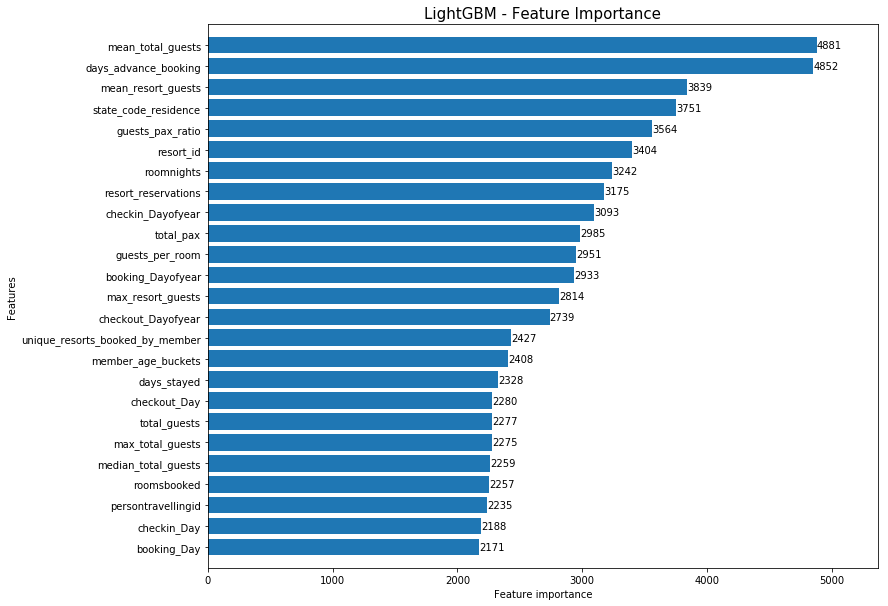

In [60]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [61]:
print(np.mean(err_lgb,0)) #96.88290556479197

96.82642649488777


In [62]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_tot_lgb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,7.950775
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.454322
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.519111
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.826066
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.788188


## Catboost Model - 5 fold crossvalidation

In [63]:
cat_idxs = []
for col in categorical_columns:
    col_idx = df_train.columns.get_loc(col)
    cat_idxs.append(col_idx)

In [64]:
%%time
errcb=[]
y_pred_totcb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model=CatBoostRegressor(n_estimators=3000
                            ,random_state=1994
                            ,eval_metric='RMSE'
                            ,max_depth=6
                            ,learning_rate=0.01
                            ,od_wait=30
                            ,cat_features=cat_idxs
                            ,use_best_model=True
                            ,colsample_bylevel=0.5
                           )
    model.fit(X_train , y_train
              , eval_set=[(X_test, y_test)]
              , early_stopping_rounds=50
#               , plot = True
              , verbose = 250)
    preds=model.predict(X_test)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    errcb.append(rmse(preds, y_test))
    p = model.predict(df_test)
    p[p < 0] = 0
    y_pred_totcb.append(p)

0:	learn: 7.7208204	test: 7.7215040	best: 7.7215040 (0)	total: 170ms	remaining: 8m 29s
250:	learn: 1.1920192	test: 1.1893872	best: 1.1893872 (250)	total: 30.2s	remaining: 5m 31s
500:	learn: 0.9870309	test: 0.9812537	best: 0.9812537 (500)	total: 1m 4s	remaining: 5m 20s
750:	learn: 0.9776891	test: 0.9718395	best: 0.9718395 (750)	total: 1m 35s	remaining: 4m 46s
1000:	learn: 0.9743905	test: 0.9689066	best: 0.9689066 (1000)	total: 2m 7s	remaining: 4m 14s
1250:	learn: 0.9723566	test: 0.9673982	best: 0.9673982 (1250)	total: 2m 38s	remaining: 3m 41s
1500:	learn: 0.9707328	test: 0.9663683	best: 0.9663683 (1500)	total: 3m 8s	remaining: 3m 8s
1750:	learn: 0.9693608	test: 0.9656321	best: 0.9656321 (1750)	total: 3m 40s	remaining: 2m 36s
2000:	learn: 0.9682288	test: 0.9651116	best: 0.9651116 (2000)	total: 4m 11s	remaining: 2m 5s
2250:	learn: 0.9672081	test: 0.9646855	best: 0.9646852 (2249)	total: 4m 43s	remaining: 1m 34s
2500:	learn: 0.9662554	test: 0.9643197	best: 0.9643197 (2500)	total: 5m 15s	rem

In [65]:
print(np.mean(errcb,0)) #97.09361367641054

97.03143008203533


In [66]:
fstrs = model.get_feature_importance(prettified=True)
feature_df = pd.DataFrame(fstrs,columns=['Feature','Score'])
display_all(feature_df.head(25))

,Feature,Score
0,days_stayed,16.763076
1,roomsbooked,15.001944
2,total_pax,7.730334
3,same_day_reservations,7.034819
4,persontravellingid,5.826313
5,max_resort_guests,4.899368
6,mean_resort_guests,4.681911
7,main_product_code,3.460651
8,total_guests,2.835551
9,numberofadults,2.482718


In [67]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_totcb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.027203
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.393931
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.457351
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.799531
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.781952


## XGBoost Model - 5 fold crossvalidation

In [68]:
%%time
err_xgb=[]
y_pred_tot_xgb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=1994)
for train_idx, test_idx in fold.split(df_train, y):
    X_train, X_test = df_train.iloc[train_idx], df_train.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    params = {
        "eval_metric" : "rmse",
        "max_depth" : 6,
        "max_leaves": 64,
        "learning_rate" : 0.01,
        "colsample_bytree" : 0.5
    }
    xgtrain = xgb.DMatrix(X_train, y_train)
    xgval = xgb.DMatrix(X_test, y_test)
    model = xgb.train(params
                      , xgtrain
                      , 3000
                      , early_stopping_rounds=30
                      , evals=[(xgval, 'valid'), (xgtrain, 'train')]
                      , verbose_eval=100
                     )
    preds=model.predict(xgb.DMatrix(X_test), model.best_iteration)
    preds[preds < 0] = 0
    print("rmse: ",rmse(preds, y_test))
    err_xgb.append(rmse(preds, y_test))
    p = model.predict(xgb.DMatrix(df_test), model.best_iteration)
    p[p < 0] = 0
    y_pred_tot_xgb.append(p)

[0]	valid-rmse:7.23157	train-rmse:7.2309
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 30 rounds.
[100]	valid-rmse:2.80823	train-rmse:2.80644
[200]	valid-rmse:1.37796	train-rmse:1.37701
[300]	valid-rmse:1.03925	train-rmse:1.03909
[400]	valid-rmse:0.980868	train-rmse:0.980338
[500]	valid-rmse:0.970553	train-rmse:0.968915
[600]	valid-rmse:0.967633	train-rmse:0.964687
[700]	valid-rmse:0.966297	train-rmse:0.961974
[800]	valid-rmse:0.965471	train-rmse:0.959756
[900]	valid-rmse:0.96487	train-rmse:0.957789
[1000]	valid-rmse:0.964451	train-rmse:0.955996
[1100]	valid-rmse:0.964088	train-rmse:0.954319
[1200]	valid-rmse:0.963794	train-rmse:0.952718
[1300]	valid-rmse:0.963524	train-rmse:0.951248
[1400]	valid-rmse:0.96336	train-rmse:0.949904
[1500]	valid-rmse:0.963191	train-rmse:0.948596
[1600]	valid-rmse:0.963097	train-rmse:0.94736
[1700]	valid-rmse:0.962993	train-rmse:0.946172
[1800]	valid-rmse:0.962913	train-

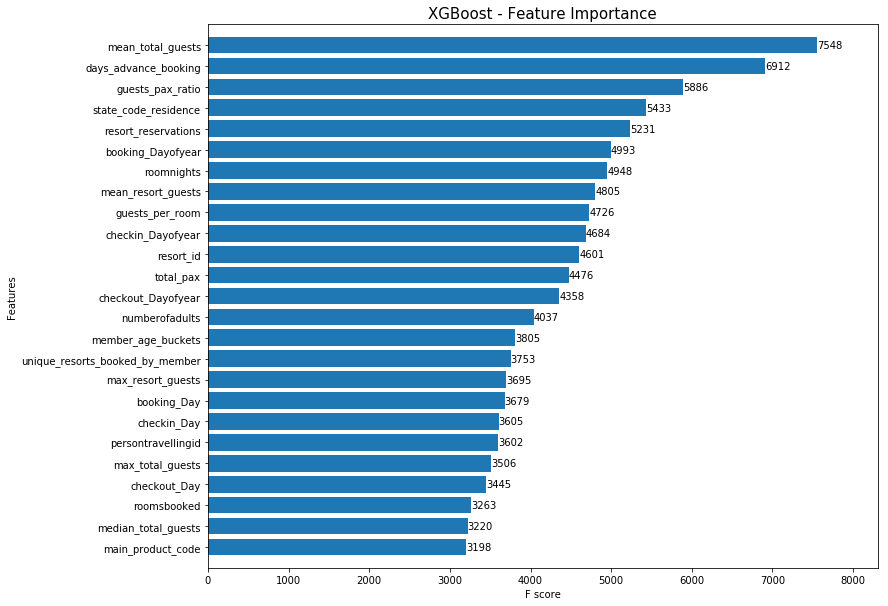

In [69]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGBoost - Feature Importance", fontsize=15)
plt.show()

In [70]:
print(np.mean(err_xgb,0)) #96.8963660231864

96.86559370120118


In [71]:
submission['amount_spent_per_room_night_scaled'] = np.mean(y_pred_tot_xgb,0)
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,7.944055
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.438006
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.520339
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.836772
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.784669


## Blender Model with LGBM, CATBoost & XGBoost

- Mean RMSE score for 3 models

In [72]:
np.mean([np.mean(err_lgb,0)
        ,np.mean(errcb,0)
        ,np.mean(err_xgb,0)
        ])

96.90781675937477

In [73]:
blender_submission = submission[['reservation_id']]
blender_submission['lgb_pred'] = np.mean(y_pred_tot_lgb,0)
blender_submission['cb_pred'] = np.mean(y_pred_totcb,0)
blender_submission['xgb_pred'] = np.mean(y_pred_tot_xgb,0)
blender_submission['amount_spent_per_room_night_scaled'] = (blender_submission['lgb_pred']
                                                           + blender_submission['cb_pred']
                                                           + blender_submission['xgb_pred']
                                                           )/3

In [74]:
blender_submission.head()

,reservation_id,lgb_pred,cb_pred,xgb_pred,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,7.950775,8.027203,7.944055,7.974011
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.454322,7.393931,7.438006,7.428753
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.519111,7.457351,7.520339,7.498934
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.826066,7.799531,7.836772,7.820789
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.788188,7.781952,7.784669,7.784936


In [75]:
blender_submission = blender_submission[['reservation_id', 'amount_spent_per_room_night_scaled']]

In [76]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='Blender'
blender_submission.to_csv(f'{Path}{model_name}_Submission_{file_timestamp}.csv', index=False)

### Playing with H2O AutoML

In [77]:
import h2o
from h2o.automl import H2OAutoML

In [78]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp2hai7vpn
  JVM stdout: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp2hai7vpn/h2o_bprudhvi_started_from_python.out
  JVM stderr: /var/folders/mv/whtm9vh50w77g26rm2tmcwgmlgk3_j/T/tmp2hai7vpn/h2o_bprudhvi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_bprudhvi_lb9oxb
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [79]:
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [80]:
X = train.columns
y = 'amount_spent_per_room_night_scaled'
X.remove(y)
X.remove('reservation_id')

In [81]:
for df in (train, test):
    for col in categorical_columns:
        df[col] = df[col].asfactor()

In [82]:
%%time
aml = H2OAutoML(max_models=30
                ,seed=2019
                ,max_runtime_secs=7200
                ,project_name="ClubMahindra"
                ,max_runtime_secs_per_model=400
               )
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 24.6 s, sys: 2.34 s, total: 26.9 s
Wall time: 1h 56min 13s


In [83]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190506_022135,0.938199,0.968607,0.938199,0.708704,0.125126
StackedEnsemble_BestOfFamily_AutoML_20190506_022135,0.939971,0.969521,0.939971,0.709748,0.125226
GBM_1_AutoML_20190506_022135,0.941961,0.970547,0.941961,0.710736,0.125335
GBM_2_AutoML_20190506_022135,0.942339,0.970741,0.942339,0.710608,0.125353
GBM_3_AutoML_20190506_022135,0.945099,0.972162,0.945099,0.711262,0.1255
GBM_5_AutoML_20190506_022135,0.951265,0.975328,0.951265,0.713779,0.125804
DeepLearning_grid_1_AutoML_20190506_022135_model_4,0.951969,0.975689,0.951969,0.716408,0.125896
DeepLearning_grid_1_AutoML_20190506_022135_model_2,0.953388,0.976416,0.953388,0.717606,0.125926
GBM_4_AutoML_20190506_022135,0.954199,0.976831,0.954199,0.713978,0.125998
DeepLearning_1_AutoML_20190506_022135,0.954792,0.977135,0.954792,0.716335,0.12608


In [84]:
preds=aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [85]:
preds=preds.as_data_frame()

In [86]:
aml_submission = submission[['reservation_id']]
aml_submission['amount_spent_per_room_night_scaled'] = preds['predict']

In [87]:
aml_submission.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.159818
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.420475
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.467711
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.792730
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.894596
